In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path='/kaggle/working/Dataset5K'
model_path='/kaggle/working/Models'
eval_path='/kaggle/working/Evaluation/Training'
model_name='vgg_5k_best.pth'
os.makedirs(model_path, exist_ok=True)
os.makedirs(eval_path, exist_ok=True)

In [3]:
import gdown
import zipfile
# File URL
file_url = "https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB"

# Output file name
output = "Dataset5K.zip"  # Replace with desired filename and extension

# Download the file
gdown.download(file_url, output, quiet=False)
print("Download completed!")


with zipfile.ZipFile('./Dataset5K.zip', 'r') as zip_ref:
    zip_ref.extractall(data_path)

Downloading...
From (original): https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB
From (redirected): https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB&confirm=t&uuid=159fea71-4045-479e-8b45-ba3fc95e44fa
To: /kaggle/working/Dataset5K.zip
100%|██████████| 287M/287M [00:04<00:00, 68.1MB/s] 


Download completed!


In [4]:
os.listdir(data_path)

['Images',
 'list_attribute.txt',
 'model_saved',
 'gender_classification.xlsx',
 'gender_classification.csv',
 'class_identity.txt']

In [5]:
images_list = os.listdir(data_path + '/Images')

In [6]:
# load the data
data = pd.read_csv(data_path + '/list_attribute.txt', sep='\\s+', skiprows=1)
# filter the data with available images only (5000 images)
filter_index = data.index.intersection(images_list)
data = data.loc[filter_index]['Male'].reset_index().rename(columns={'index':'Filename'})
data['Male'] = np.where(data['Male'] == 1, 1, 0)
data.head()

,Filename,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0


In [7]:
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data.shape, test_data.shape

((4000, 2), (1000, 2))

In [8]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        
        # please define image convertion technique to RGB here
        image = Image.open(image_path).convert('RGB')
        
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # Resize to match model input size
    transforms.RandomHorizontalFlip(),             # Randomly flip images horizontally
    transforms.RandomRotation(10),                 # Random rotation between -10 and 10 degrees
    transforms.ColorJitter(brightness=0.2,         # Random brightness, contrast, saturation
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),                         # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same as training
                         std=[0.229, 0.224, 0.225])
])

In [10]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=train_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

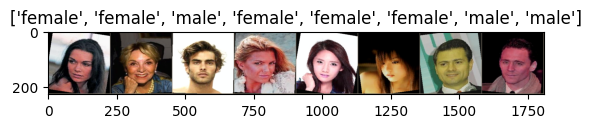

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
# limit to 8 images only
inputs = inputs[:8]
classes = classes[:8]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['female', 'male']
imshow(out, title=[class_names[x] for x in classes])

# Modeling

In [12]:
import time
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
    # please define the training model (VGG/GoogleNet/ResNet) here
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = 0

    acc_histories = []
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        acc_history = { 'train': 0, 'test': 0 }
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for data in dataloders[phase]:
                 # get the inputs
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                #resnet
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                

                # backward + optimize only if in training phase
                if phase == 'train':
                    
                    loss.backward()
                    optimizer.step()
                    
                 # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            acc_history[phase] = round(epoch_acc.item(), 4)
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state, os.path.join(model_path, model_name))
                best_epoch = epoch
                print(f'✅ Best model saved! (Accuracy: {best_acc:.4f})')
        acc_histories.append(acc_history)
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_histories, best_acc, time_elapsed, best_epoch

In [13]:
dataloders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}

In [14]:

# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16()

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)  # for 2 output classes: male/female

use_gpu = torch.cuda.is_available()
# use_gpu = False
if use_gpu:
  model = model.to("cuda")
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


In [15]:
model, acc_histories, best_acc, time_elapsed, best_epoch = train_model(model, dataloders, dataset_sizes, criterion, optimizer, use_gpu, 30)

Epoch 0/29
----------
train Loss: 0.0213 Acc: 0.5830
test Loss: 0.0219 Acc: 0.5960
✅ Best model saved! (Accuracy: 0.5960)

Epoch 1/29
----------
train Loss: 0.0194 Acc: 0.6520
test Loss: 0.0164 Acc: 0.7450
✅ Best model saved! (Accuracy: 0.7450)

Epoch 2/29
----------
train Loss: 0.0163 Acc: 0.7543
test Loss: 0.0137 Acc: 0.8010
✅ Best model saved! (Accuracy: 0.8010)

Epoch 3/29
----------
train Loss: 0.0121 Acc: 0.8230
test Loss: 0.0098 Acc: 0.8690
✅ Best model saved! (Accuracy: 0.8690)

Epoch 4/29
----------
train Loss: 0.0083 Acc: 0.8845
test Loss: 0.0067 Acc: 0.9240
✅ Best model saved! (Accuracy: 0.9240)

Epoch 5/29
----------
train Loss: 0.0065 Acc: 0.9163
test Loss: 0.0070 Acc: 0.9210

Epoch 6/29
----------
train Loss: 0.0057 Acc: 0.9283
test Loss: 0.0057 Acc: 0.9400
✅ Best model saved! (Accuracy: 0.9400)

Epoch 7/29
----------
train Loss: 0.0051 Acc: 0.9330
test Loss: 0.0075 Acc: 0.9130

Epoch 8/29
----------
train Loss: 0.0044 Acc: 0.9448
test Loss: 0.0050 Acc: 0.9470
✅ Best mode

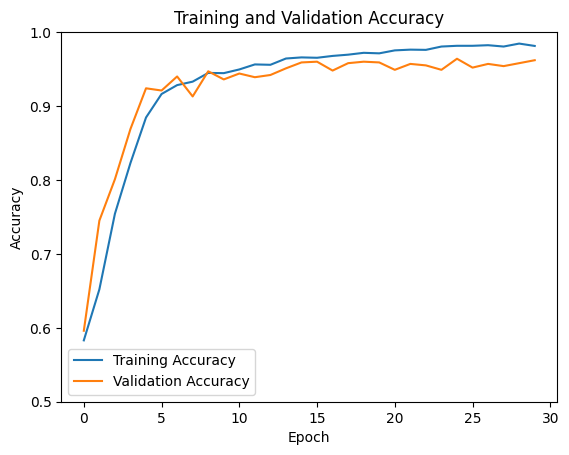

In [16]:
train_values = np.array([item['train'] for item in acc_histories])
test_values = np.array([item['test'] for item in acc_histories])
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(train_values, label='Training Accuracy')
plt.plot(test_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.00)
plt.legend()
plt.savefig(os.path.join(eval_path, model_name + '_train_acc.png'), dpi=300)
plt.show()

In [17]:
df = pd.DataFrame({'train': train_values, 'test': test_values})
df.to_csv(os.path.join(eval_path, model_name + '_train_acc.csv'))

In [18]:
df_sum = pd.DataFrame({'mode': [model_name], 
                       'device': [torch.cuda.get_device_name(0)], 
                       'time_elapsed' : [time_elapsed],
                       'best_epoch': [best_epoch],
                       'best_acc': [best_acc.cpu().item()]})
df_sum.to_csv(os.path.join(eval_path, model_name + '_train_sum.csv'))